## NAME- HIBAH MOHAMMED GHOUSE
## ZID-Z1945894


Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score



Loading data and analysis

In [2]:
fileURL = "https://github.com/Hibah45/AppliedML/blob/main/healthcare-dataset-stroke-data.csv?raw=True"

df = pd.read_csv(fileURL)

df.head(5)

target = df['stroke']

In [3]:
df.shape

(5110, 12)

In [4]:
df['stroke'].value_counts() #highly imbalanced data

0    4861
1     249
Name: stroke, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [6]:
df.apply(lambda x:sum(x.isnull()),axis=0)

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [7]:
df.isnull().sum()/len(df)

id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  0.039335
smoking_status       0.000000
stroke               0.000000
dtype: float64

In [8]:
df.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

Observation- Except age, avg_glucose_level and bmi all other features has less unique values

## 1. Train a Decision Tree, Random Forest and Gradient Boosting algorithm to set a baseline performance. Use ROC AUC and Average Precision metrics for your evaluation. Also, show the precision and recall for both classes. Don’t balance the dataset.

In [9]:
target = df['stroke']
data = df.drop(['stroke', 'id'], axis = 1);

In [10]:
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked


In [11]:
num = data.select_dtypes(exclude=object)
numerical_features = list(num)

cat = data.select_dtypes(include=object)
categorical_features = list(cat)


In [12]:
numerical_features

['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

In [13]:
categorical_features

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

Handling missing values

In [14]:
ohe = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
ct = make_column_transformer((ohe, categorical_features), (imputer, numerical_features), (scaler, numerical_features))


# numeric transformer imputes missing numeric data with values using mean strategy then performance normalization using standardscaler
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")), 
    ("scaler", StandardScaler())
])


# categorical transformer imputes NaN categorical values with string 'missing' which is treated as a new value 
# then applies OneHotEncoding on imputed data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])


# preprocessor applies above two transoformations in that order
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)



In [15]:
trainX, testX, trainY, testY = train_test_split(data, target, test_size=0.3)

In [16]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report

def getMetrics(pipeline, X, y, testX, testY, cv = 3):
    scores = cross_validate(pipeline, X, y, cv=cv, scoring=('roc_auc', 'average_precision', 'recall'))
    pipeline.fit(X, y)
    predY = pipeline.predict(testX);
    return scores['test_roc_auc'].mean(), scores['test_average_precision'].mean(), scores['test_recall'].mean(), classification_report(predY, testY)


def printMetrics(pipeline, X, y, testX, testY, cv = 3):
    roc, avg_precision, recall, clf_report = getMetrics(pipeline, X, y, testX, testY, cv = 3)
    print("roc = ", roc)
    print("average precision = ", avg_precision)
    print("recall = " , recall)
    print("classification report\n", clf_report, "\n");

Model evaluation with imbalanced dataset

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

tree_clf = DecisionTreeClassifier(max_depth=4)
decision_tree_pipe = make_pipeline(preprocessor, tree_clf)


rf_clf = RandomForestClassifier(max_depth=2, random_state=0)
rf_pipe = make_pipeline(preprocessor, rf_clf)

gb_clf = GradientBoostingClassifier()
gb_pipe = make_pipeline(preprocessor, gb_clf)


print("Decision tree accuracy before balancing ")
printMetrics(decision_tree_pipe, trainX, trainY, testX, testY, cv=5)
print("Random forest accuracy before balancing ")
printMetrics(rf_pipe, trainX, trainY, testX, testY,cv=5)
print("Gradient boosting algorithm accuracy before balancing ")
printMetrics(gb_pipe, trainX, trainY, testX, testY,cv=5)


Decision tree accuracy before balancing 
roc =  0.7664599938855564
average precision =  0.13986881053946196
recall =  0.04253647586980921
classification report
               precision    recall  f1-score   support

           0       1.00      0.95      0.97      1532
           1       0.01      1.00      0.02         1

    accuracy                           0.95      1533
   macro avg       0.51      0.97      0.50      1533
weighted avg       1.00      0.95      0.97      1533
 

Random forest accuracy before balancing 


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


roc =  0.8362221073402565
average precision =  0.19709076478799403
recall =  0.0
classification report
               precision    recall  f1-score   support

           0       1.00      0.94      0.97      1533
           1       0.00      0.00      0.00         0

    accuracy                           0.94      1533
   macro avg       0.50      0.47      0.49      1533
weighted avg       1.00      0.94      0.97      1533
 

Gradient boosting algorithm accuracy before balancing 
roc =  0.8227618099183731
average precision =  0.17282924137327582
recall =  0.054994388327721654
classification report
               precision    recall  f1-score   support

           0       1.00      0.95      0.97      1527
           1       0.05      0.67      0.09         6

    accuracy                           0.95      1533
   macro avg       0.52      0.81      0.53      1533
weighted avg       0.99      0.95      0.97      1533
 



In [18]:
!pip install -U imbalanced-learn

     |████████████████████████████████| 199 kB 5.5 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


##Q2. Balance the dataset using any 4 methods we have discussed in the class and again train a Decision Tree, Random Forest and Gradient Boosting algorithm to compare the performance with models from Q1.

Model evaluation- DATA BALANCING TECHNIQUES

In [19]:
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import CondensedNearestNeighbour

undersample_tree_pipe = make_imb_pipeline(RandomUnderSampler(), decision_tree_pipe)
oversample_tree_pipe = make_imb_pipeline(RandomOverSampler(), decision_tree_pipe)
tree_enn_pipe = make_imb_pipeline(preprocessor, EditedNearestNeighbours(n_neighbors=5), DecisionTreeClassifier(max_depth=4))


tree_with_cw = DecisionTreeClassifier(max_depth=4, class_weight='balanced')
tree_with_cw_pipe = make_pipeline(preprocessor, tree_with_cw)



print("decision tree metrics after undersampling")
printMetrics(undersample_tree_pipe, trainX, trainY, testX, testY, 5)

print("decision tree metrics after oversampling")
printMetrics(oversample_tree_pipe, trainX, trainY, testX, testY, 5)

print("decision tree metrics with class weights")
printMetrics(tree_with_cw_pipe, trainX, trainY, testX, testY, 5)

print("decision tree metrics with edited nearst neighbors")
printMetrics(tree_enn_pipe, trainX, trainY, testX, testY, 5)




decision tree metrics after undersampling
roc =  0.791331904319092
average precision =  0.12038118342890548
recall =  0.7615039281705949
classification report
               precision    recall  f1-score   support

           0       0.69      0.98      0.81      1018
           1       0.78      0.13      0.22       515

    accuracy                           0.69      1533
   macro avg       0.73      0.55      0.52      1533
weighted avg       0.72      0.69      0.61      1533
 

decision tree metrics after oversampling
roc =  0.7665779456676168
average precision =  0.1316753369393453
recall =  0.7059483726150392
classification report
               precision    recall  f1-score   support

           0       0.73      0.98      0.84      1077
           1       0.79      0.15      0.25       456

    accuracy                           0.73      1533
   macro avg       0.76      0.57      0.54      1533
weighted avg       0.75      0.73      0.66      1533
 

decision tree metrics w

In [20]:
undersample_rf_pipe = make_imb_pipeline(RandomUnderSampler(), gb_pipe)
oversample_rf_pipe = make_imb_pipeline(RandomOverSampler(), gb_pipe)
rf_enn_pipe = make_imb_pipeline(preprocessor, EditedNearestNeighbours(n_neighbors=5), RandomForestClassifier())

rf_with_cw = RandomForestClassifier(class_weight='balanced')
rf_with_cw_pipe = make_pipeline(preprocessor, rf_with_cw)

print("Random Forest metrics after undersampling")
printMetrics(undersample_rf_pipe, trainX, trainY, testX, testY, 5)

print("Random Forest metrics after oversampling")
printMetrics(oversample_rf_pipe, trainX, trainY, testX, testY, 5)

print("Random Forest metrics with class weights")
printMetrics(rf_with_cw_pipe, trainX, trainY, testX, testY, 5)


print("Random Forest metrics with edited nearst neighbors")
printMetrics(rf_enn_pipe, trainX, trainY, testX, testY, 5)


Random Forest metrics after undersampling
roc =  0.8113156472250563
average precision =  0.1408020717921383
recall =  0.7677890011223344
classification report
               precision    recall  f1-score   support

           0       0.72      0.98      0.83      1055
           1       0.78      0.14      0.23       478

    accuracy                           0.72      1533
   macro avg       0.75      0.56      0.53      1533
weighted avg       0.73      0.72      0.64      1533
 

Random Forest metrics after oversampling
roc =  0.8173788009704607
average precision =  0.15739915606352706
recall =  0.542648709315376
classification report
               precision    recall  f1-score   support

           0       0.81      0.97      0.88      1200
           1       0.62      0.16      0.25       333

    accuracy                           0.80      1533
   macro avg       0.72      0.57      0.57      1533
weighted avg       0.77      0.80      0.75      1533
 

Random Forest metrics w

In [21]:
undersample_gb_pipe = make_imb_pipeline(RandomUnderSampler(), gb_pipe)
oversample_gb_pipe = make_imb_pipeline(RandomOverSampler(), gb_pipe)
gb_enn_pipe = make_imb_pipeline(preprocessor, EditedNearestNeighbours(n_neighbors=5), GradientBoostingClassifier())
gb_cnn_pipe = make_imb_pipeline(preprocessor, CondensedNearestNeighbour(), GradientBoostingClassifier())


print("gradient boosing algorithm metrics after undersampling")
printMetrics(undersample_gb_pipe, trainX, trainY, testX, testY, 5)

print("gradient boosing algorithm metrics after oversampling")
printMetrics(oversample_gb_pipe, trainX, trainY, testX, testY, 5)

print("gradient boosing algorithm metrics with edited nearst neighbors")
printMetrics(gb_enn_pipe, trainX, trainY, testX, testY, 5)


print("gradient boosing algorithm metrics with condensed nearst neighbors")
printMetrics(gb_cnn_pipe, trainX, trainY, testX, testY, 5)


gradient boosing algorithm metrics after undersampling
roc =  0.8088689347179144
average precision =  0.16079169275531202
recall =  0.7921436588103256
classification report
               precision    recall  f1-score   support

           0       0.72      0.98      0.83      1074
           1       0.71      0.13      0.22       459

    accuracy                           0.72      1533
   macro avg       0.72      0.55      0.53      1533
weighted avg       0.72      0.72      0.65      1533
 

gradient boosing algorithm metrics after oversampling
roc =  0.8127922256656106
average precision =  0.1687934839565024
recall =  0.49966329966329964
classification report
               precision    recall  f1-score   support

           0       0.80      0.97      0.88      1198
           1       0.61      0.16      0.25       335

    accuracy                           0.79      1533
   macro avg       0.71      0.56      0.56      1533
weighted avg       0.76      0.79      0.74      153

Observation- Performance increases by applying data balancing techniques

## 3. Find the important features using Random Forest and Gradient Boosting algorithms.

Feature importance

In [22]:
data.head(5)
data.shape

(5110, 10)

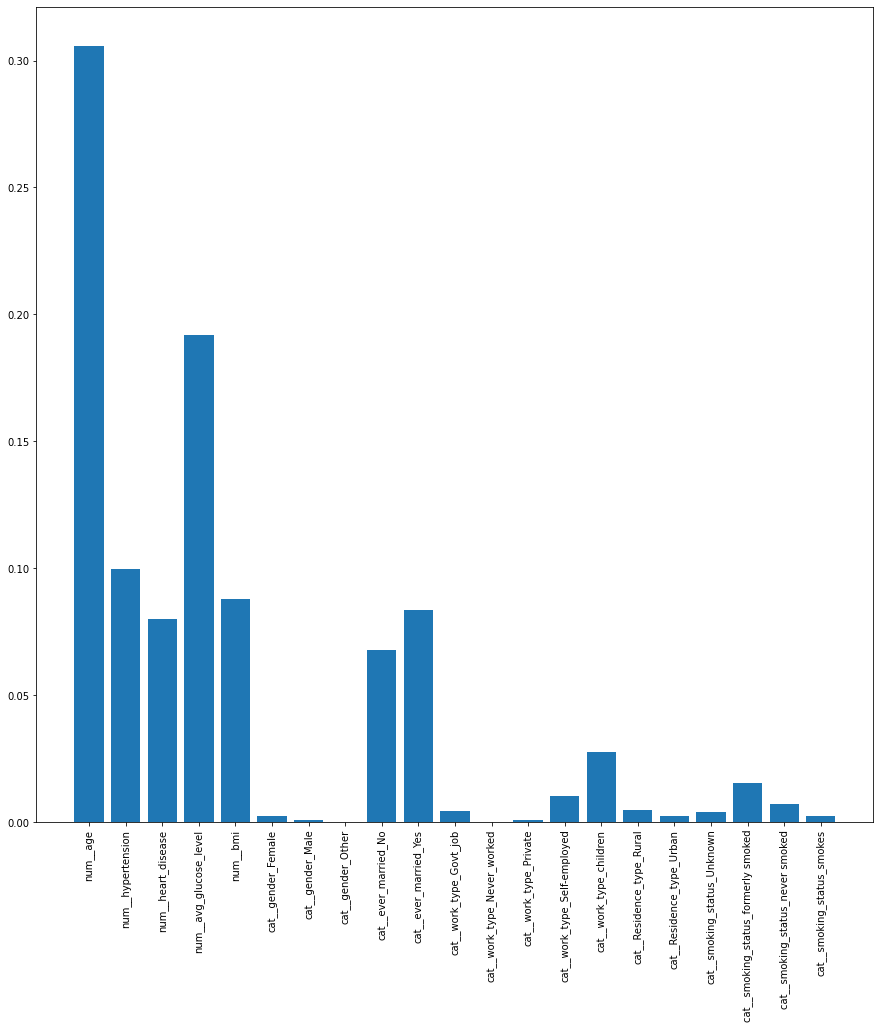

In [23]:
# feature importance of Random forest
#column_names = ['gender','age','hypertension','heart_disease','ever_married','work_type','residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']
feature_after_encoding = ['num__age',
 'num__hypertension',
 'num__heart_disease',
 'num__avg_glucose_level',
 'num__bmi',
 'cat__gender_Female',
 'cat__gender_Male',
 'cat__gender_Other',
 'cat__ever_married_No',
 'cat__ever_married_Yes',
 'cat__work_type_Govt_job',
 'cat__work_type_Never_worked',
 'cat__work_type_Private',
 'cat__work_type_Self-employed',
 'cat__work_type_children',
 'cat__Residence_type_Rural',
 'cat__Residence_type_Urban',
 'cat__smoking_status_Unknown',
 'cat__smoking_status_formerly smoked',
 'cat__smoking_status_never smoked',
 'cat__smoking_status_smokes']
plt.figure(figsize=(15, 15))
plt.bar(feature_after_encoding, rf_clf.feature_importances_)
plt.xticks(range(len(feature_after_encoding)), feature_after_encoding, rotation='vertical')
plt.show()

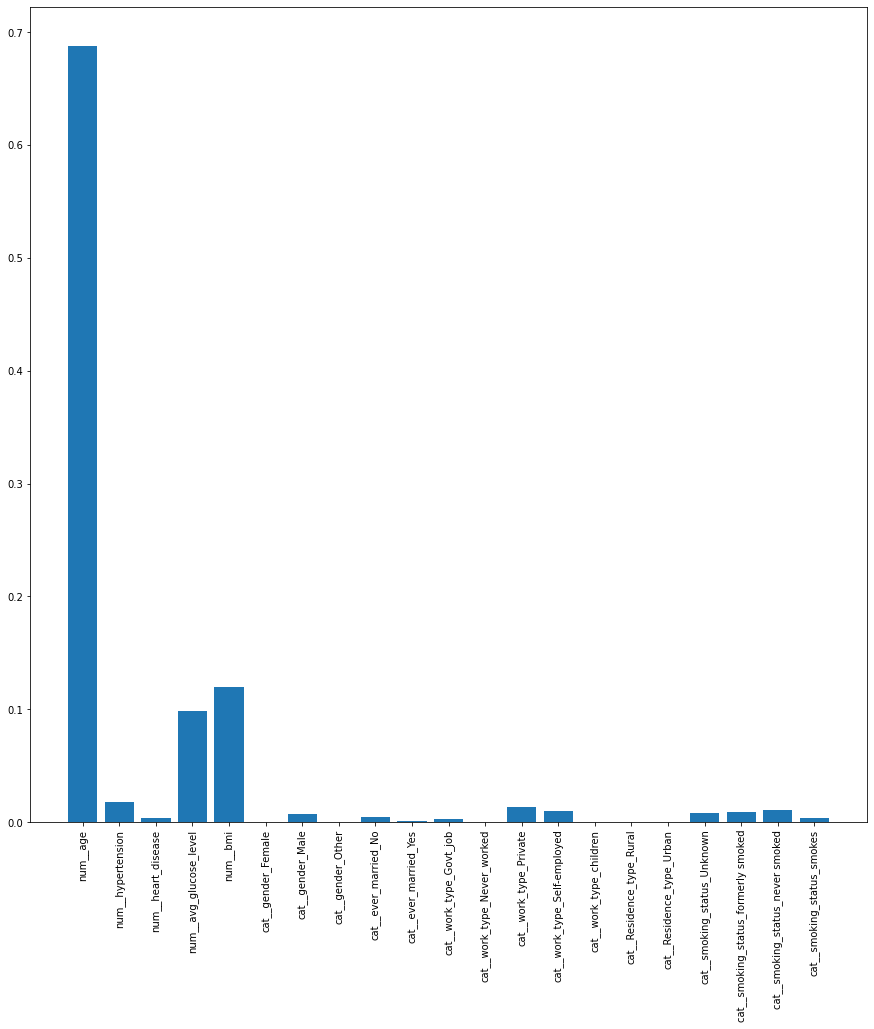

In [24]:
# feature importance of gradient boosting algorithm
plt.figure(figsize=(15, 15))
plt.bar(feature_after_encoding, gb_clf.feature_importances_)
plt.xticks(range(len(feature_after_encoding)), feature_after_encoding, rotation='vertical')
plt.show()

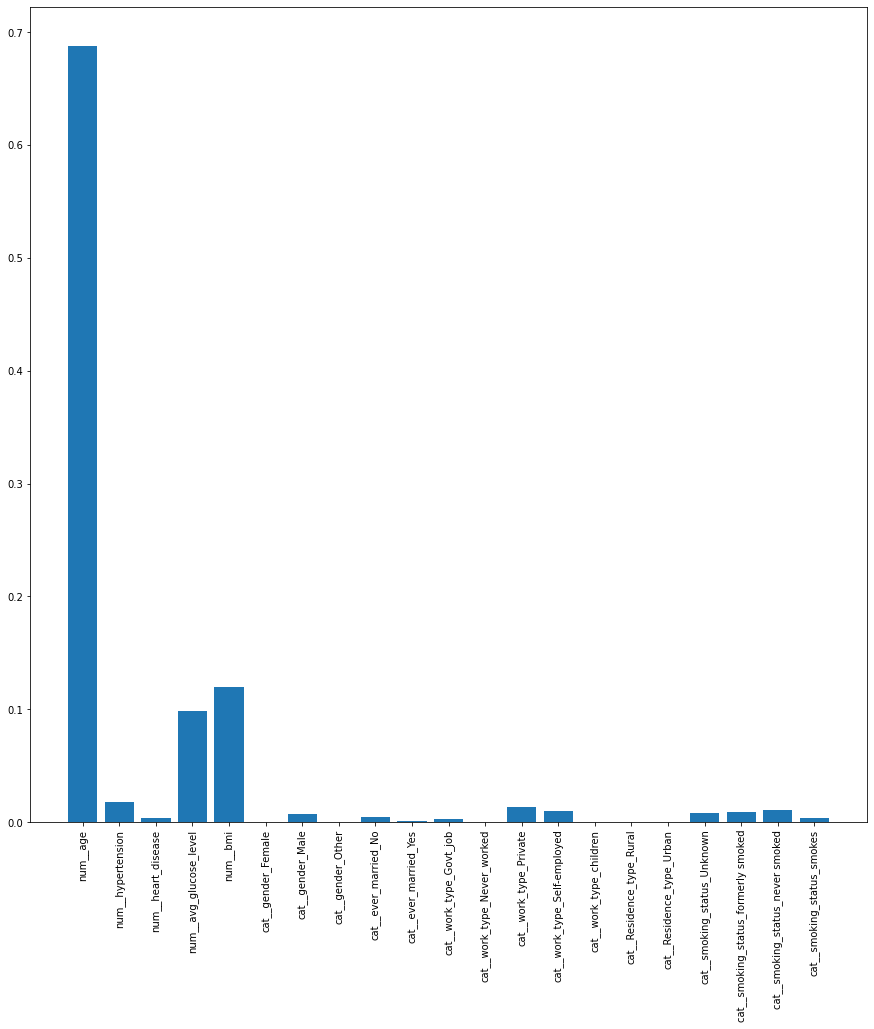

In [25]:
# feature importance of decision trees 
plt.figure(figsize=(15, 15))
plt.bar(feature_after_encoding, gb_clf.feature_importances_)
plt.xticks(range(len(feature_after_encoding)), feature_after_encoding, rotation='vertical')
plt.show()

Observation- Age, avg_glucose_level, bmi_level are the important features in gradient boosting and random forest algorithms while some features are not at all important.

## Q4. Write a brief report on how different data balancing techniques improved the performance of your models.

Answer: 

Considering all the algorithms we used above, the performance is improved when data balancing techniques are applied. To understand what metric to use to evaluate performance completely depends on predictive model. For example, if the aim is to have a predictive model for both binary classes as accurate as possible, f1 score or roc_auc would be a good choice. However, if the only thing we need is to predict patients with stroke as accurate as possible, recall would be more appropriate.

The recall is intuitively the ability of the classifier to find all the positive samples. Decision tree performs well with imbalanced dataset, whereas after applying data balancing technique the recall score is closer to 1 for undersampling, oversampling and class weight techniques which says it has better performance.
The precision falls a bit but the metric used for evaluation-recall increases. Edited nearest neighbours technique applied to the Decision tree algorithm doesn't perform well with a recall score of 0.25 which is much less than all other techniques.

Random Forest had a recall score of 0 with imbalanced dataset, whereas after applying the undersampling and oversampling techniques it performs better. The other two techniques has less recall value which means less ability to find true samples. It has a good decision boundary roc curve for all the techniques.

Gradient Boosting algorithm can be seen as a best model with imbalanced dataset. Data balancing technique has improved the performance in classifying majority and minority samples(oversampling and undersampling technique). Roc curve is also high.